In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from imutils import paths
import imutils
import numpy as np
import argparse
import random
import pickle
import cv2
import os

C:\Users\dhruv\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
# link to data
data_root = 'C:/Users/dhruv/Downloads/split_data/split_data'

In [3]:
# initialize the data and labels
data = []
labels = []
dir_labels = ()
num_class = 0


In [4]:
print("[INFO] Finding Labels...")
for file in os.listdir(data_root) :
    temp_tuple=(file,'null')
    dir_labels=dir_labels+temp_tuple
    dir_labels=dir_labels[:-1]
    print(dir_labels)
    num_class=num_class+1
    print(num_class)

[INFO] Finding Labels...
('0',)
1
('0', '1')
2
('0', '1', '2')
3
('0', '1', '2', '3')
4
('0', '1', '2', '3', '4')
5
('0', '1', '2', '3', '4', '5')
6
('0', '1', '2', '3', '4', '5', '6')
7
('0', '1', '2', '3', '4', '5', '6', '7')
8
('0', '1', '2', '3', '4', '5', '6', '7', '8')
9
('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
10


In [5]:
# grab the image paths and randomly shuffle them
print("[INFO] Loading Images...")
imagePaths = sorted(list(paths.list_images(data_root)))
random.seed(3)
random.shuffle(imagePaths)

[INFO] Loading Images...


In [6]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store in a list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (28, 28)) # 28 x 28 x 1
    image = img_to_array(image)
    data.append(image)
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    for i in range(num_class) :
        if label == dir_labels[i] :
            label = i
    #print(label) 
    labels.append(label)

In [7]:
# scale pixel intensities to the range [0, 1]
data = np.array(data, dtype='float') / 255.0 # 0 to 255
labels = np.array(labels)

In [8]:
# the data for training 80% and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=42)

In [9]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=num_class)
testY = to_categorical(testY, num_classes=num_class)

In [10]:
# Model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K


class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        '''
        initialize the model
        '''
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using 'channels first', update the input shape
        if K.image_data_format() == 'channels_first':
            inputShape = (depth, height, width)

        # first set of CONV => ReLU => POOL layers
        model.add(Conv2D(20, (5, 5), padding='same', input_shape=inputShape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second layer of CONV => ReLU => POOL layers
        model.add(Conv2D(50, (5, 5), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => ReLU layeres
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))

        return model

In [11]:
print('[INFO] compiling model...')
model = LeNet.build(width=28, height=28, depth=1, classes=num_class)
model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

[INFO] compiling model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [12]:
# train the network
print('[INFO] training network...')
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=25, verbose=1)

[INFO] training network...

Train on 224 samples, validate on 56 samples
Epoch 1/25
224/224 [==============================] - 1s 3ms/step - loss: 2.3593 - accuracy: 0.0938 - val_loss: 2.2988 - val_accuracy: 0.1071
Epoch 2/25
224/224 [==============================] - 0s 2ms/step - loss: 2.3092 - accuracy: 0.1205 - val_loss: 2.3076 - val_accuracy: 0.0714
Epoch 3/25
224/224 [==============================] - 0s 2ms/step - loss: 2.3025 - accuracy: 0.1071 - val_loss: 2.3162 - val_accuracy: 0.0714
Epoch 4/25
224/224 [==============================] - 0s 2ms/step - loss: 2.2978 - accuracy: 0.1071 - val_loss: 2.3229 - val_accuracy: 0.0714
Epoch 5/25
224/224 [==============================] - 0s 1ms/step - loss: 2.2972 - accuracy: 0.1205 - val_loss: 2.3061 - val_accuracy: 0.0357
Epoch 6/25
224/224 [==============================] - 0s 2ms/step - loss: 2.2830 - accuracy: 0.1250 - val_loss: 2.3100 - val_accuracy: 0.0357
Epoch 7/25
224/224 [==============================] - 0s 2ms/step - loss: 2

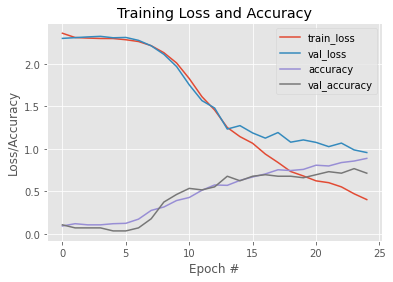

In [13]:
plt.style.use('ggplot')
plt.figure()
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['val_loss'], label='val_loss')
plt.plot(H.history['accuracy'], label='accuracy')
plt.plot(H.history['val_accuracy'], label='val_accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

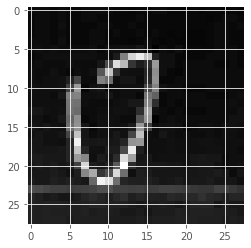

In [14]:
#view data 
def draw(n):
    plt.imshow(n,cmap=plt.cm.binary)
    plt.show()
     
draw(trainX[0])

label ->  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
prediction ->  2


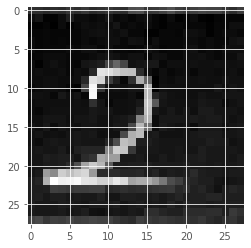

In [16]:
# prediction using model 
predictions=model.predict([testX])
print('label -> ',testY[4])
print('prediction -> ',np.argmax(predictions[4]))
 
draw(testX[4])

In [17]:
#saving the model
model.save('Digit_recognizer.h5')